In [119]:
from socceraction.data.wyscout import PublicWyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.opta import OptaLoader
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.spadl.config import actiontypes, bodyparts
import socceraction.spadl as spadl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import math
import pickle
from mplsoccer import Pitch
import hashlib
import copy

In [120]:
# DATA STRUCTURE FOR PATH TO FINAL TIMESTAMP
class Node_Decision_Making:
    def __init__(self, timestamp, player_id, coordinate_x, coordinate_y):
        self.timestamp = timestamp
        self.player_id = player_id
        self.coordinate = (coordinate_x, coordinate_y)
        self.xgoal_value = None

    def get_timestamp(self):
        return self.timestamp
    
    def set_timestamp(self, timestamp):
        self.timestamp = timestamp
    
    def get_player_id(self):
        return self.player_id
    
    def set_player_id(self, player_id):
        self.player_id = player_id
    
    def get_xgoal_value(self):
        return self.xgoal_value
    
    def set_xgoal_value(self, xgoal_value):
        self.xgoal_value = xgoal_value

    def get_coordinate_value(self):
        return self.coordinate
    
    def set_coordinate_value(self, coordinate_x, coordinate_y):
        self.coordinate = (coordinate_x, coordinate_y)

class Xpass_Value_Decision_Making:
    def __init__(self, node_start, node_end, xpass_value):
        self.node_start = node_start
        self.node_end = node_end
        self.unique_id = hashlib.md5((str(node_start.get_player_id()) + '-' + str(node_start.get_timestamp()) \
                            + '-' + str(node_end.get_player_id()) + '-' + str(node_end.get_timestamp())) \
                            .encode('utf-8').hexdigest())
        self.xpass_value = xpass_value

    def get_unique_id(self):
        return self.unique_id

    def get_node_start(self):
        return self.node_start
    
    def set_node_start(self, node):
        self.node_start = node

    def get_node_end(self):
        return self.node_end
    
    def set_node_end(self, node):
        self.node_end = node

    def get_xpass_value(self):
        return self.xpass_value
    
    def set_xpass_value(self, xpass_value):
        self.xpass_value = xpass_value

class Path_Decision_Making:
    def __init__(self):
        self.path_list = []
        self.xpass_values = []

    def append_new_node_in_path(self, timestamp, player_id, coordinate_x, coordinate_y):
        new_node = Node_Decision_Making(timestamp, player_id, coordinate_x, coordinate_y)
        if len(self.path_list) > 0:
            last_node_in_this_path = self.path_list[-1]
            xpass_object = Xpass_Value_Decision_Making(last_node_in_this_path, new_node, 0)
            self.xpass_values.append(xpass_object)
        self.path_list.append(new_node)

    def get_path_list(self):
        return self.path_list
    
    def get_specific_node_by_index(self, index):
        return self.path_list[index]
    
    def get_xpass_values(self):
        return self.xpass_values
    
    def get_index_with_greatest_xg(self):
        greatest_xg = self.path_list[0].get_xgoal_value()
        idx_greatest_xg = 0
        for idx, node_class in enumerate(self.path_list):
            if node_class.get_xgoal_value() > greatest_xg:
                greatest_xg = node_class.get_xgoal_value()
                idx_greatest_xg = idx
        return idx_greatest_xg
    
    def get_xpass_value_from_start_and_end_nodes(self, node_start, node_end):
        xpass_value = 0
        unique_id_xpass_obj = hashlib.md5((str(node_start.get_player_id()) + '-' + str(node_start.get_timestamp()) \
                            + '-' + str(node_end.get_player_id()) + '-' + str(node_end.get_timestamp())) \
                            .encode('utf-8').hexdigest())
        for _, xpass_class in enumerate(self.xpass_values):
            if xpass_class.get_unique_id() == unique_id_xpass_obj:
                xpass_value = xpass_class.get_xpass_value()
        return xpass_value
    
    def set_xpass_value_from_start_and_end_nodes(self, node_start, node_end, xpass_value):
        unique_id_xpass_obj = hashlib.md5((str(node_start.get_player_id()) + '-' + str(node_start.get_timestamp()) \
                            + '-' + str(node_end.get_player_id()) + '-' + str(node_end.get_timestamp())) \
                            .encode('utf-8').hexdigest())
        for _, xpass_class in enumerate(self.xpass_values):
            if xpass_class.get_unique_id() == unique_id_xpass_obj:
                xpass_class.set_xpass_value(xpass_value)


In [121]:
COLUMNS_XPASS_MODEL = ["timestamp_origin", "timestamp_target", "player_id_src", "player_id_target", "start_x", "start_y", "end_x", "end_y", "bodypart_id", "distance_pass", "is_home_team"]
COLUMNS_XGOAL_MODEL = ["timestamp", "player_id", "distance_to_goal", "angle_to_goal", "is_home_team", "bodypart_id"]
STANDARD_LENGTH_COURT = 105
STANDARD_WIDTH_COURT = 68
STANDARD_GOALLINE_WIDTH = 7.32

# Load Model from External Directory
def load_model_from_external_file_pickle(filename_path):
    return pickle.load(open(filename_path, 'rb'))

# Create Dataframe from Raw Input Coordinate Player
def load_df_raw_input_coordinate_player(filename_path):
    return pd.read_csv(filename_path, delimiter=";")

# Helper to calculate distance pass
def calculate_distance_pass(coordinate_x, coordinate_y, end_x, end_y):
    distance_passing = math.sqrt((abs(end_x - coordinate_x)) ** 2 + (abs(end_y - coordinate_y)) ** 2)
    return distance_passing

# Helper to calculate distance to opponent's goal
def calculate_distance_to_goal(length_court, width_court, coordinate_x, coordinate_y, is_home_team):
    if is_home_team:
        distance_to_goal = math.sqrt((abs(length_court - coordinate_x)) ** 2 + (abs((0.5 * width_court) - coordinate_y)) ** 2)
    else:
        distance_to_goal = math.sqrt((coordinate_x) ** 2 + (abs((0.5 * width_court) - coordinate_y)) ** 2)
    return distance_to_goal

# Helper to calculate angle to opponent's goal
# def calculate_angle_to_goal(goalline_width, length_court, width_court, coordinate_x, coordinate_y, is_home_team):
#     if is_home_team:
#         L = abs(length_court - coordinate_x)
#     else:
#         L = coordinate_x
#     W = abs((0.5 * width_court) - coordinate_y)
#     return math.atan((goalline_width * L) / (L ** 2 + W ** 2 - (goalline_width / 2) ** 2))

# Helper to calculate angle to opponent's goal v2
def calculate_angle_to_goal_v2(goalline_width, length_court, width_court, coordinate_x, coordinate_y, is_home_team):
    if is_home_team:
        coordinate_x_post_1, coordinate_x_post_2 = (length_court, length_court)
    else:
        coordinate_x_post_1, coordinate_x_post_2 = (0, 0)
    coordinate_y_post_1 = (width_court / 2) + (goalline_width / 2)
    coordinate_y_post_2 = (width_court / 2) - (goalline_width / 2)

    distance_to_post_1 = math.sqrt(abs(coordinate_x - coordinate_x_post_1) ** 2 + abs(coordinate_y - coordinate_y_post_1) ** 2)
    distance_to_post_2 = math.sqrt(abs(coordinate_x - coordinate_x_post_2) ** 2 + abs(coordinate_y - coordinate_y_post_2) ** 2)

    return math.acos((distance_to_post_1 ** 2 + distance_to_post_2 ** 2 - goalline_width ** 2) / (2 * distance_to_post_1 * distance_to_post_2))

# Generate list of Path_Decision_Making objects from input csv decision making model
def generate_list_path_objects_from_df_raw_input(df_raw_input, player_id_start, player_id_final, num_of_steps):
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    if ((num_of_steps > len(unique_timestamps)) or (num_of_steps < 2) or (num_of_steps == None)):
        num_of_steps = len(unique_timestamps)
    unique_player_ids = df_raw_input['player_id'].unique()
    considered_timestamps = unique_timestamps[:num_of_steps]
    idx_timestamp_control = 0
    initial_start_timestamp = 1
    maps_of_paths = {}
    node_visited = [(player_id_start, initial_start_timestamp)]
    copy_of_node_visited = []
    
    while idx_timestamp_control < (len(considered_timestamps)-1):
        timestamp_next = considered_timestamps[idx_timestamp_control + 1]
        copy_of_node_visited = copy.deepcopy(node_visited)
        node_visited.clear()
        player_id_targets = [player_id_final] if (idx_timestamp_control == (len(considered_timestamps)-2)) else unique_player_ids
        for player_id_next in player_id_targets:
            node_visited.append((player_id_next, timestamp_next))
        for player_id_prev, timestamp_prev in copy_of_node_visited:
            for player_id_next in player_id_targets:
                if (player_id_prev, timestamp_prev) in maps_of_paths:
                    maps_of_paths[(player_id_prev, timestamp_prev)].append((player_id_next, timestamp_next))
                else:
                    maps_of_paths[(player_id_prev, timestamp_prev)] = [(player_id_next, timestamp_next)]
        idx_timestamp_control += 1

    
    return maps_of_paths

# Construct xpass dataset from input csv decision making model
def construct_xpass_dataset_from_df_raw_input(df_raw_input):
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    empty_xpass_df = pd.DataFrame(columns=COLUMNS_XPASS_MODEL, index=[0])

    for timestamp in unique_timestamps:
        df_raw_this_timestamp = df_raw_input[df_raw_input['timestamp'] == timestamp]
        unique_id_players_this_timestamp = df_raw_this_timestamp['player_id'].unique()
        for player_id_source in unique_id_players_this_timestamp:
            for player_id_target in unique_id_players_this_timestamp:
                if player_id_source == player_id_target:
                    continue
                # Select Features
                start_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "coordinate_x"].iloc[0]
                start_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "coordinate_y"].iloc[0]
                end_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_target, "coordinate_x"].iloc[0]
                end_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_target, "coordinate_y"].iloc[0]
                is_home_team = 1 if (df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id_source, "is_opponent_team"].iloc[0] == 0) else 0
                # Bodypart ID is assumed to be foot (id = 0) for now
                bodypart_id = 0
                distance_pass = calculate_distance_pass(start_x, start_y, end_x, end_y)
                # Append new row to (empty) xpass dataframe
                new_row = pd.DataFrame({"timestamp": timestamp, "player_id_src": player_id_source, "player_id_target": player_id_target, 
                           "start_x": start_x, "start_y": start_y, "end_x": end_x, "end_y": end_y, 
                           "bodypart_id": bodypart_id, "distance_pass": distance_pass, "is_home_team": is_home_team}, index=[0])
                empty_xpass_df = pd.concat([new_row, empty_xpass_df.loc[:]]).reset_index(drop=True)

    return empty_xpass_df

# Construct xgoal dataset from input csv decision making model
def construct_xgoal_dataset_from_df_raw_input(df_raw_input):
    unique_timestamps = sorted(df_raw_input['timestamp'].unique())
    empty_xgoal_df = pd.DataFrame(columns=COLUMNS_XGOAL_MODEL, index=[0])

    for timestamp in unique_timestamps:
        df_raw_this_timestamp = df_raw_input[df_raw_input['timestamp'] == timestamp]
        unique_id_players_this_timestamp = df_raw_this_timestamp['player_id'].unique()
        for player_id in unique_id_players_this_timestamp:
            # Select Features
            start_x = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            is_home_team = 1 if (df_raw_this_timestamp.loc[df_raw_this_timestamp["player_id"] == player_id, "is_opponent_team"].iloc[0] == 0) else 0
            # Bodypart ID is assumed to be foot (id = 0) for now
            bodypart_id = 0
            distance_to_goal = calculate_distance_to_goal(STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, is_home_team)
            angle_to_goal = calculate_angle_to_goal_v2(STANDARD_GOALLINE_WIDTH, STANDARD_LENGTH_COURT, STANDARD_WIDTH_COURT, start_x, start_y, is_home_team)
            # Append new row to (empty) xpass dataframe
            new_row = pd.DataFrame({"timestamp": timestamp, "player_id": player_id, "distance_to_goal": distance_to_goal, "angle_to_goal": angle_to_goal, "is_home_team": is_home_team, "bodypart_id": bodypart_id}, index=[0])
            empty_xgoal_df = pd.concat([new_row, empty_xgoal_df.loc[:]]).reset_index(drop=True)

    return empty_xgoal_df

In [122]:
INPUT_RAW_PLAYER_COORDINATE_FILEPATH = "data/input_decision_making_model/input_coordinate_player.csv"

raw_input_coordinate_player_df = load_df_raw_input_coordinate_player(INPUT_RAW_PLAYER_COORDINATE_FILEPATH)

maps = generate_list_path_objects_from_df_raw_input(raw_input_coordinate_player_df, 1, 3, 5)
for key, value in maps.items():
    print("KEY : ", key)
    print("VALUE : ", value)

Timestamp :  1
COPY OF VISITED :  [(1, 1)]
VISITED :  []
Timestamp :  2
COPY OF VISITED :  [(1, 2), (2, 2), (3, 2)]
VISITED :  []
Timestamp :  3
COPY OF VISITED :  [(1, 3), (2, 3), (3, 3)]
VISITED :  []
Timestamp :  4
COPY OF VISITED :  [(1, 4), (2, 4), (3, 4)]
VISITED :  []
ISI :  {(1, 1): [(1, 2), (2, 2), (3, 2)], (1, 2): [(1, 3), (2, 3), (3, 3)], (2, 2): [(1, 3), (2, 3), (3, 3)], (3, 2): [(1, 3), (2, 3), (3, 3)], (1, 3): [(1, 4), (2, 4), (3, 4)], (2, 3): [(1, 4), (2, 4), (3, 4)], (3, 3): [(1, 4), (2, 4), (3, 4)], (1, 4): [(3, 5)], (2, 4): [(3, 5)], (3, 4): [(3, 5)]}
KEY :  (1, 1)
VALUE :  [(1, 2), (2, 2), (3, 2)]
KEY :  (1, 2)
VALUE :  [(1, 3), (2, 3), (3, 3)]
KEY :  (2, 2)
VALUE :  [(1, 3), (2, 3), (3, 3)]
KEY :  (3, 2)
VALUE :  [(1, 3), (2, 3), (3, 3)]
KEY :  (1, 3)
VALUE :  [(1, 4), (2, 4), (3, 4)]
KEY :  (2, 3)
VALUE :  [(1, 4), (2, 4), (3, 4)]
KEY :  (3, 3)
VALUE :  [(1, 4), (2, 4), (3, 4)]
KEY :  (1, 4)
VALUE :  [(3, 5)]
KEY :  (2, 4)
VALUE :  [(3, 5)]
KEY :  (3, 4)
VALUE :  [

In [123]:
# FINAL XPASS DATAFRAME
xpass_dataframes_test = construct_xpass_dataset_from_df_raw_input(raw_input_coordinate_player_df)
xpass_dataframes_test.dropna(inplace=True)
xpass_dataframes_test

,timestamp,player_id_src,player_id_target,start_x,start_y,end_x,end_y,bodypart_id,distance_pass,is_home_team,timestamp_origin,timestamp_target


In [124]:
# FINAL XGOAL DATAFRAME
xgoal_dataframes_test = construct_xgoal_dataset_from_df_raw_input(raw_input_coordinate_player_df)
xgoal_dataframes_test.dropna(inplace=True)
xgoal_dataframes_test

,timestamp,player_id,distance_to_goal,angle_to_goal,is_home_team,bodypart_id
0,5,3,7.000000,0.963531,1,0
1,5,2,36.674242,0.179454,1,0
2,5,1,26.248809,0.213396,1,0
3,4,3,50.000000,0.146139,1,0
4,4,2,47.759816,0.144254,1,0
5,4,1,37.121422,0.175203,1,0
6,3,3,56.000000,0.130529,1,0
7,3,2,57.280014,0.122592,1,0
8,3,1,55.659680,0.125116,1,0
9,2,3,59.000000,0.123909,1,0


In [125]:
# FUNCTION TO PREPROCESS FINAL XPASS DATAFRAME
def preprocess_xpass_test(xpass_df):
    # 1. Change start_x, start_y, end_x, end_y with StandardScaler
    # scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    columns = ["start_x", "start_y", "end_x", "end_y", "distance_pass"]
    xpass_df[columns] = scaler.fit_transform(xpass_df[columns])

    # 2. Change incorrect type of bodypart_id and is_home_team columns
    xpass_df['bodypart_id'] = xpass_df['bodypart_id'].astype("int64")
    xpass_df['is_home_team'] = xpass_df['is_home_team'].astype("int64")

    return xpass_df

# VERIFY XPASS PROBABILITY BASED ON MODEL
filename = "xgbRegressor_xpass_model.sav"
directory_model = "data/model_xpass_wyscout/"
xpass_model = pickle.load(open(directory_model + filename, 'rb'))

xpass_dataframes_test_verify = xpass_dataframes_test.copy(deep=True)
xpass_dataframes_test_verify = preprocess_xpass_test(xpass_dataframes_test_verify)
featured_column_based_on_model = ["start_x", "start_y", "end_x", "end_y", "bodypart_id", "distance_pass", "is_home_team"]
X_test = xpass_dataframes_test_verify[featured_column_based_on_model]
print(X_test)
y_verify_result = xpass_model.predict(X_test)

xpass_dataframes_test['probability_score'] = y_verify_result
xpass_dataframes_test

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by MinMaxScaler.

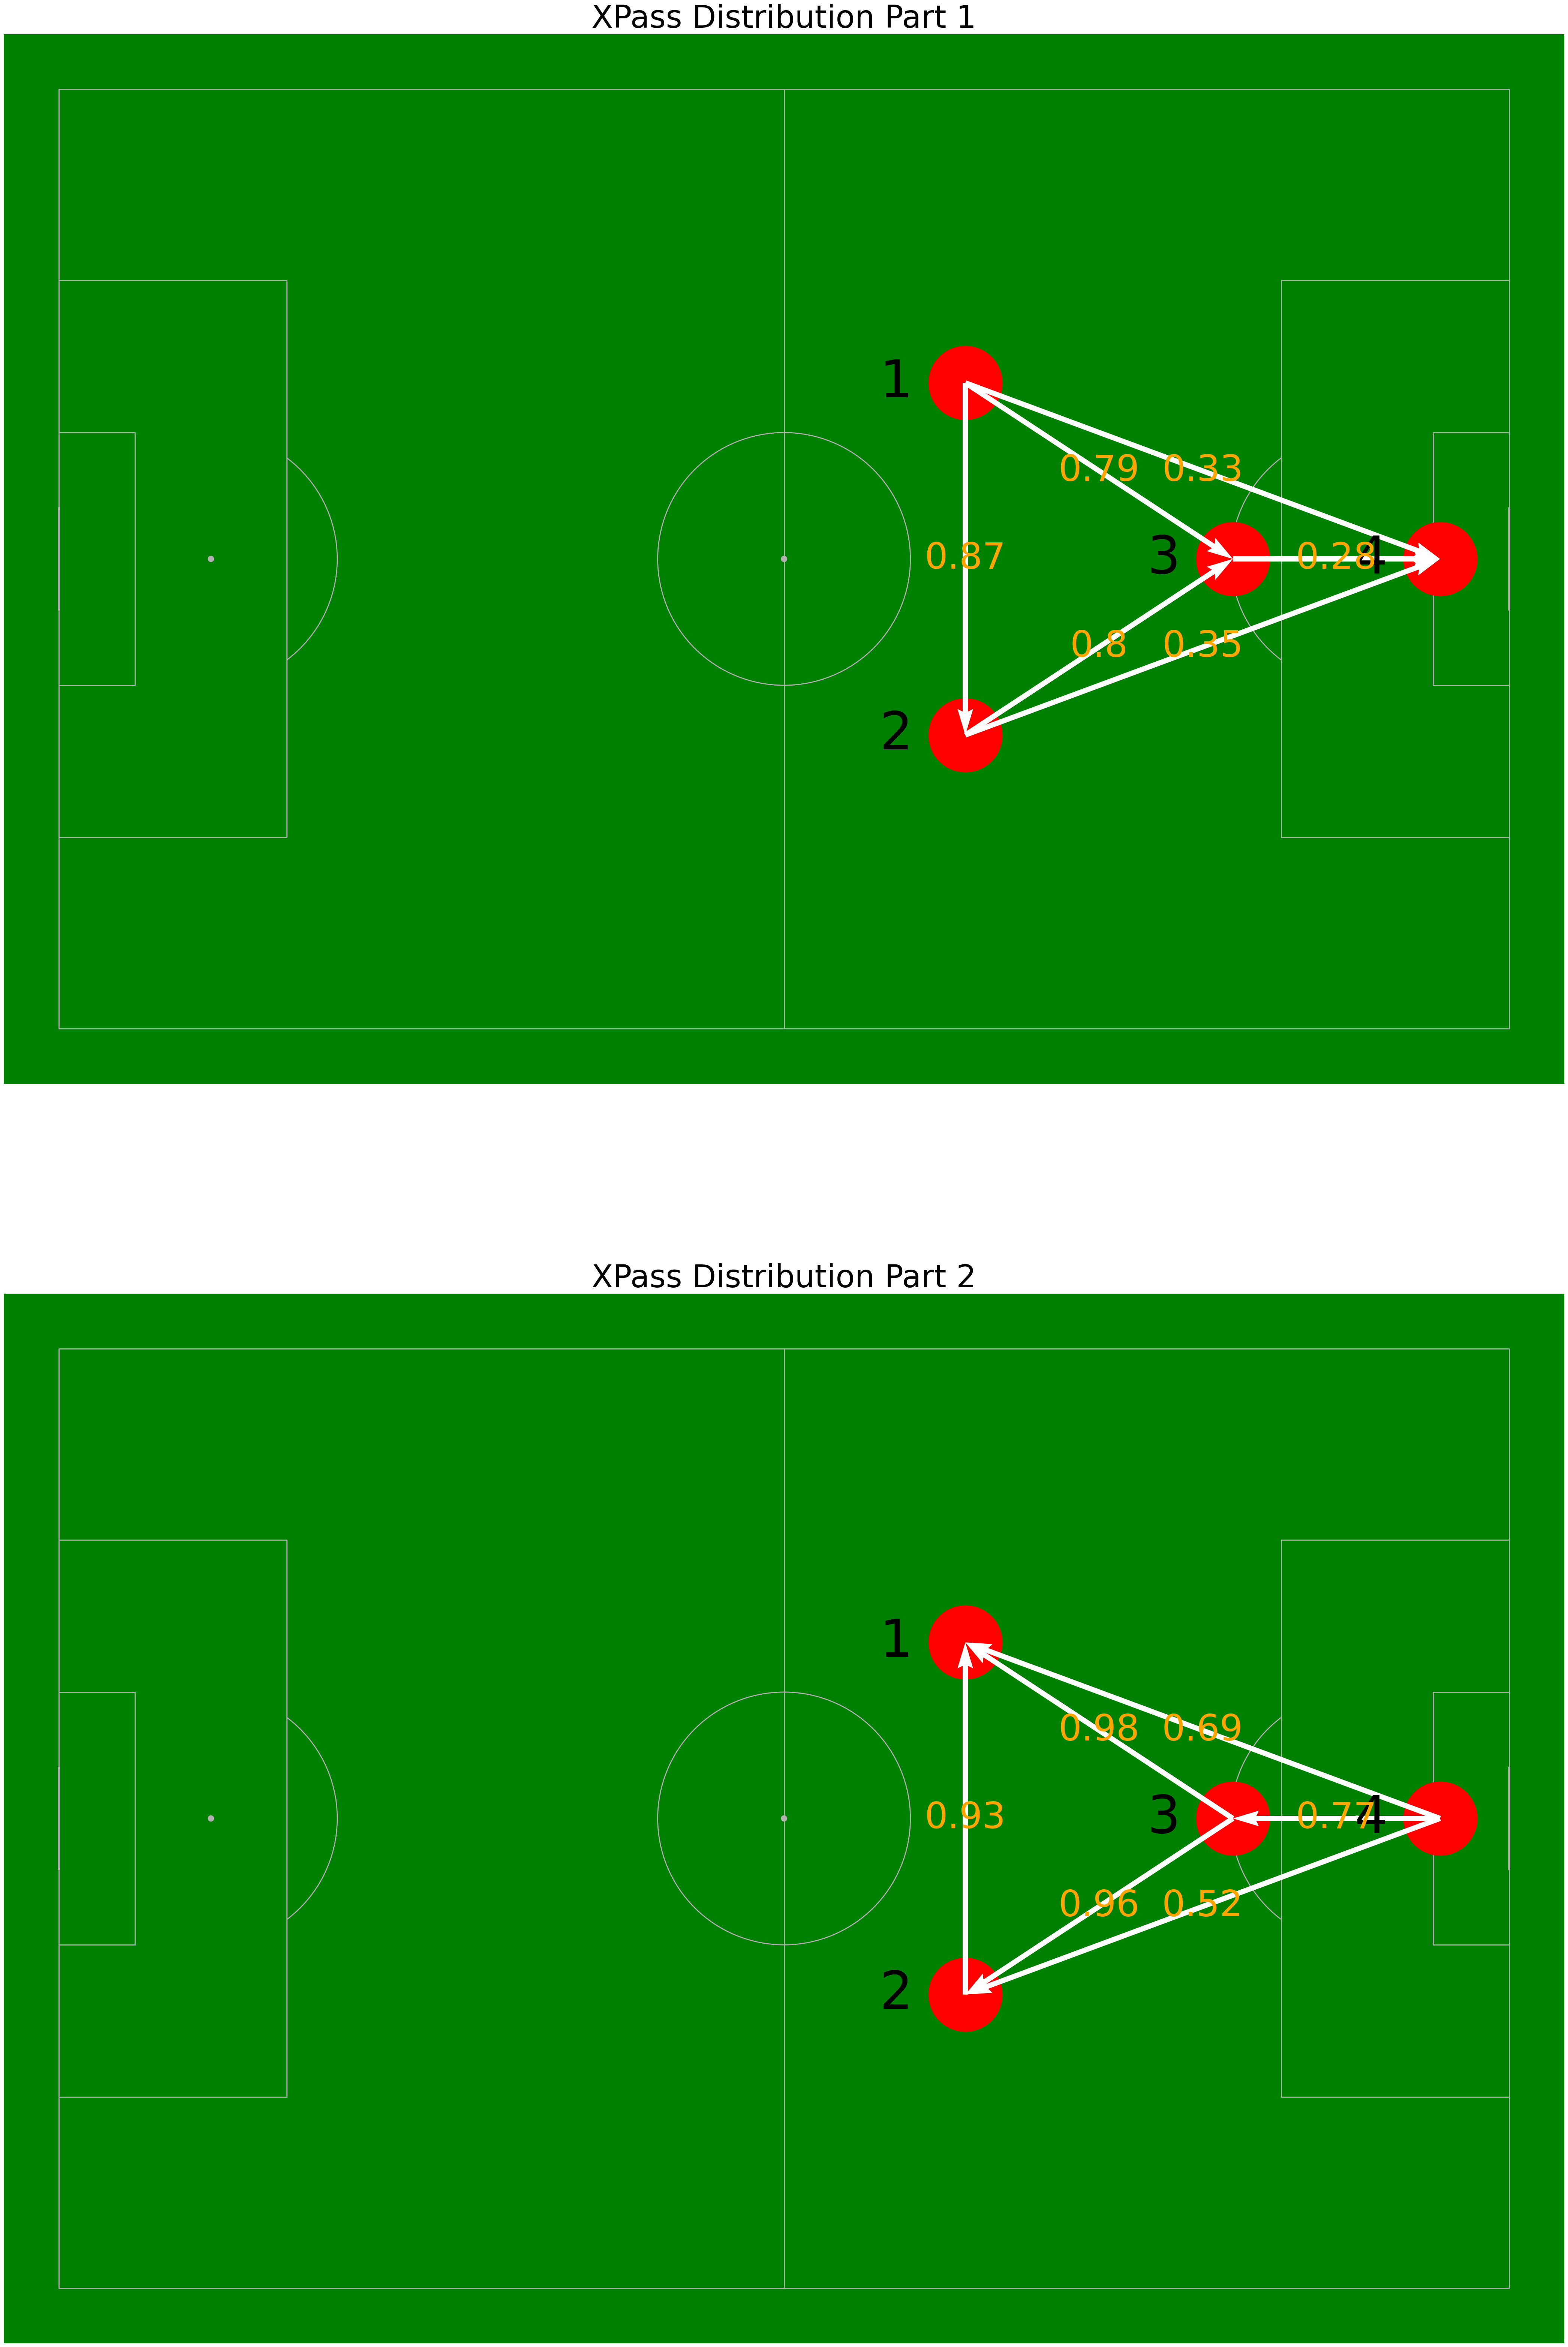

In [ ]:
# PLOT PASS PROBABILITY INTO PITCH IMAGE
def plot_passing_probability_network(raw_input_from_csv, xpass_final_df):
    fig, axs = plt.subplots(2,1)
    fig.set_figheight(80)
    fig.set_figwidth(100)
    pitchXPass_part1 = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    pitchXPass_part1.draw(axs[0], figsize=(200,100), constrained_layout=True, tight_layout=False)
    axs[0].set_title("XPass Distribution Part 1", fontsize=60)
    pitchXPass_part2 = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    pitchXPass_part2.draw(axs[1], figsize=(200,100), constrained_layout=True, tight_layout=False)
    axs[1].set_title("XPass Distribution Part 2", fontsize=60)

    timestamps_sorted = sorted(raw_input_from_csv['timestamp'].unique())
    for timestamp in timestamps_sorted:
        raw_input_this_timestamp = raw_input_from_csv[raw_input_from_csv['timestamp'] == timestamp]
        unique_player_ids_this_timestamp = raw_input_this_timestamp['player_id'].unique()

        for player_id in unique_player_ids_this_timestamp:
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            idx_column = 0
            for pitch in [pitchXPass_part1, pitchXPass_part2]:
                pitch.scatter(x=start_x, y=start_y, color="red", ax=axs[idx_column], s=20000)
                axs[idx_column].annotate(text=player_id, xy=(start_x - 5, start_y), ha="center", va="center", size=100)
                idx_column += 1

        list_unique_arrows = []
        for player_id_src in unique_player_ids_this_timestamp:
            for player_id_target in unique_player_ids_this_timestamp:
                if player_id_src == player_id_target:
                    continue
                if ((player_id_src, player_id_target) not in list_unique_arrows) and ((player_id_target, player_id_src) not in list_unique_arrows):
                    list_unique_arrows.append((player_id_src, player_id_target))
                    pitch = pitchXPass_part1
                    idx_column = 0
                else:
                    pitch = pitchXPass_part2
                    idx_column = 1
                specific_row_xpass_df = xpass_final_df.loc[(xpass_final_df["player_id_src"] == player_id_src) & (xpass_final_df["player_id_target"] == player_id_target), ["start_x", "start_y", "end_x", "end_y", "probability_score"]].iloc[0]
                pitch.arrows(xstart=specific_row_xpass_df["start_x"], ystart=specific_row_xpass_df["start_y"], xend=specific_row_xpass_df["end_x"], yend=specific_row_xpass_df["end_y"], ax=axs[idx_column], color="white", width=10)
                x_line = (specific_row_xpass_df["end_x"] + specific_row_xpass_df["start_x"]) / 2
                y_line = (specific_row_xpass_df["end_y"] + specific_row_xpass_df["start_y"]) / 2   
                axs[idx_column].annotate(text=str(round(specific_row_xpass_df["probability_score"], 2)), xy=(x_line, y_line), ha="center", va="center", size=70, color="orange")
    
    plt.show()

plot_passing_probability_network(raw_input_coordinate_player_df, xpass_dataframes_test)

In [ ]:
# FUNCTION TO PREPROCESS FINAL XGOAL DATAFRAME
def preprocess_xgoal_test(xgoal_df):
    # 1. Change start_x, start_y, end_x, end_y with StandardScaler
    # scaler = preprocessing.StandardScaler()
    scaler = preprocessing.MinMaxScaler()
    columns = ["distance_to_goal", "angle_to_goal"]
    xgoal_df[columns] = scaler.fit_transform(xgoal_df[columns])

    # 2. Change incorrect type of bodypart_id and is_home_team columns
    xgoal_df['bodypart_id'] = xgoal_df['bodypart_id'].astype("int64")
    xgoal_df['is_home_team'] = xgoal_df['is_home_team'].astype("int64")

    return xgoal_df

# VERIFY XGOAL PROBABILITY BASED ON MODEL
filename = "xgbRegressor_xgoal_model.sav"
directory_model = "data/model_xgoal_wyscout/"
xgoal_model = pickle.load(open(directory_model + filename, 'rb'))

xgoal_dataframes_test_verify = xgoal_dataframes_test.copy(deep=True)
xgoal_dataframes_test_verify = preprocess_xgoal_test(xgoal_dataframes_test_verify)
featured_column_based_on_model = ["distance_to_goal", "angle_to_goal", "is_home_team", "bodypart_id"]
X_test = xgoal_dataframes_test_verify[featured_column_based_on_model]
print(X_test)
y_verify_result = xgoal_model.predict(X_test)

xgoal_dataframes_test['probability_score'] = y_verify_result
xgoal_dataframes_test

   distance_to_goal  angle_to_goal  is_home_team  bodypart_id
0          0.000000       1.000000             1            0
1          0.412226       0.177048             1            0
2          1.000000       0.000000             1            0
3          1.000000       0.000000             1            0


,timestamp,player_id,distance_to_goal,angle_to_goal,is_home_team,bodypart_id,probability_score
0,1,4,5.000000,1.263762,1,0,0.718553
1,1,3,20.000000,0.361995,1,0,0.197934
2,1,2,41.387838,0.167990,1,0,0.110204
3,1,1,41.387838,0.167990,1,0,0.110204


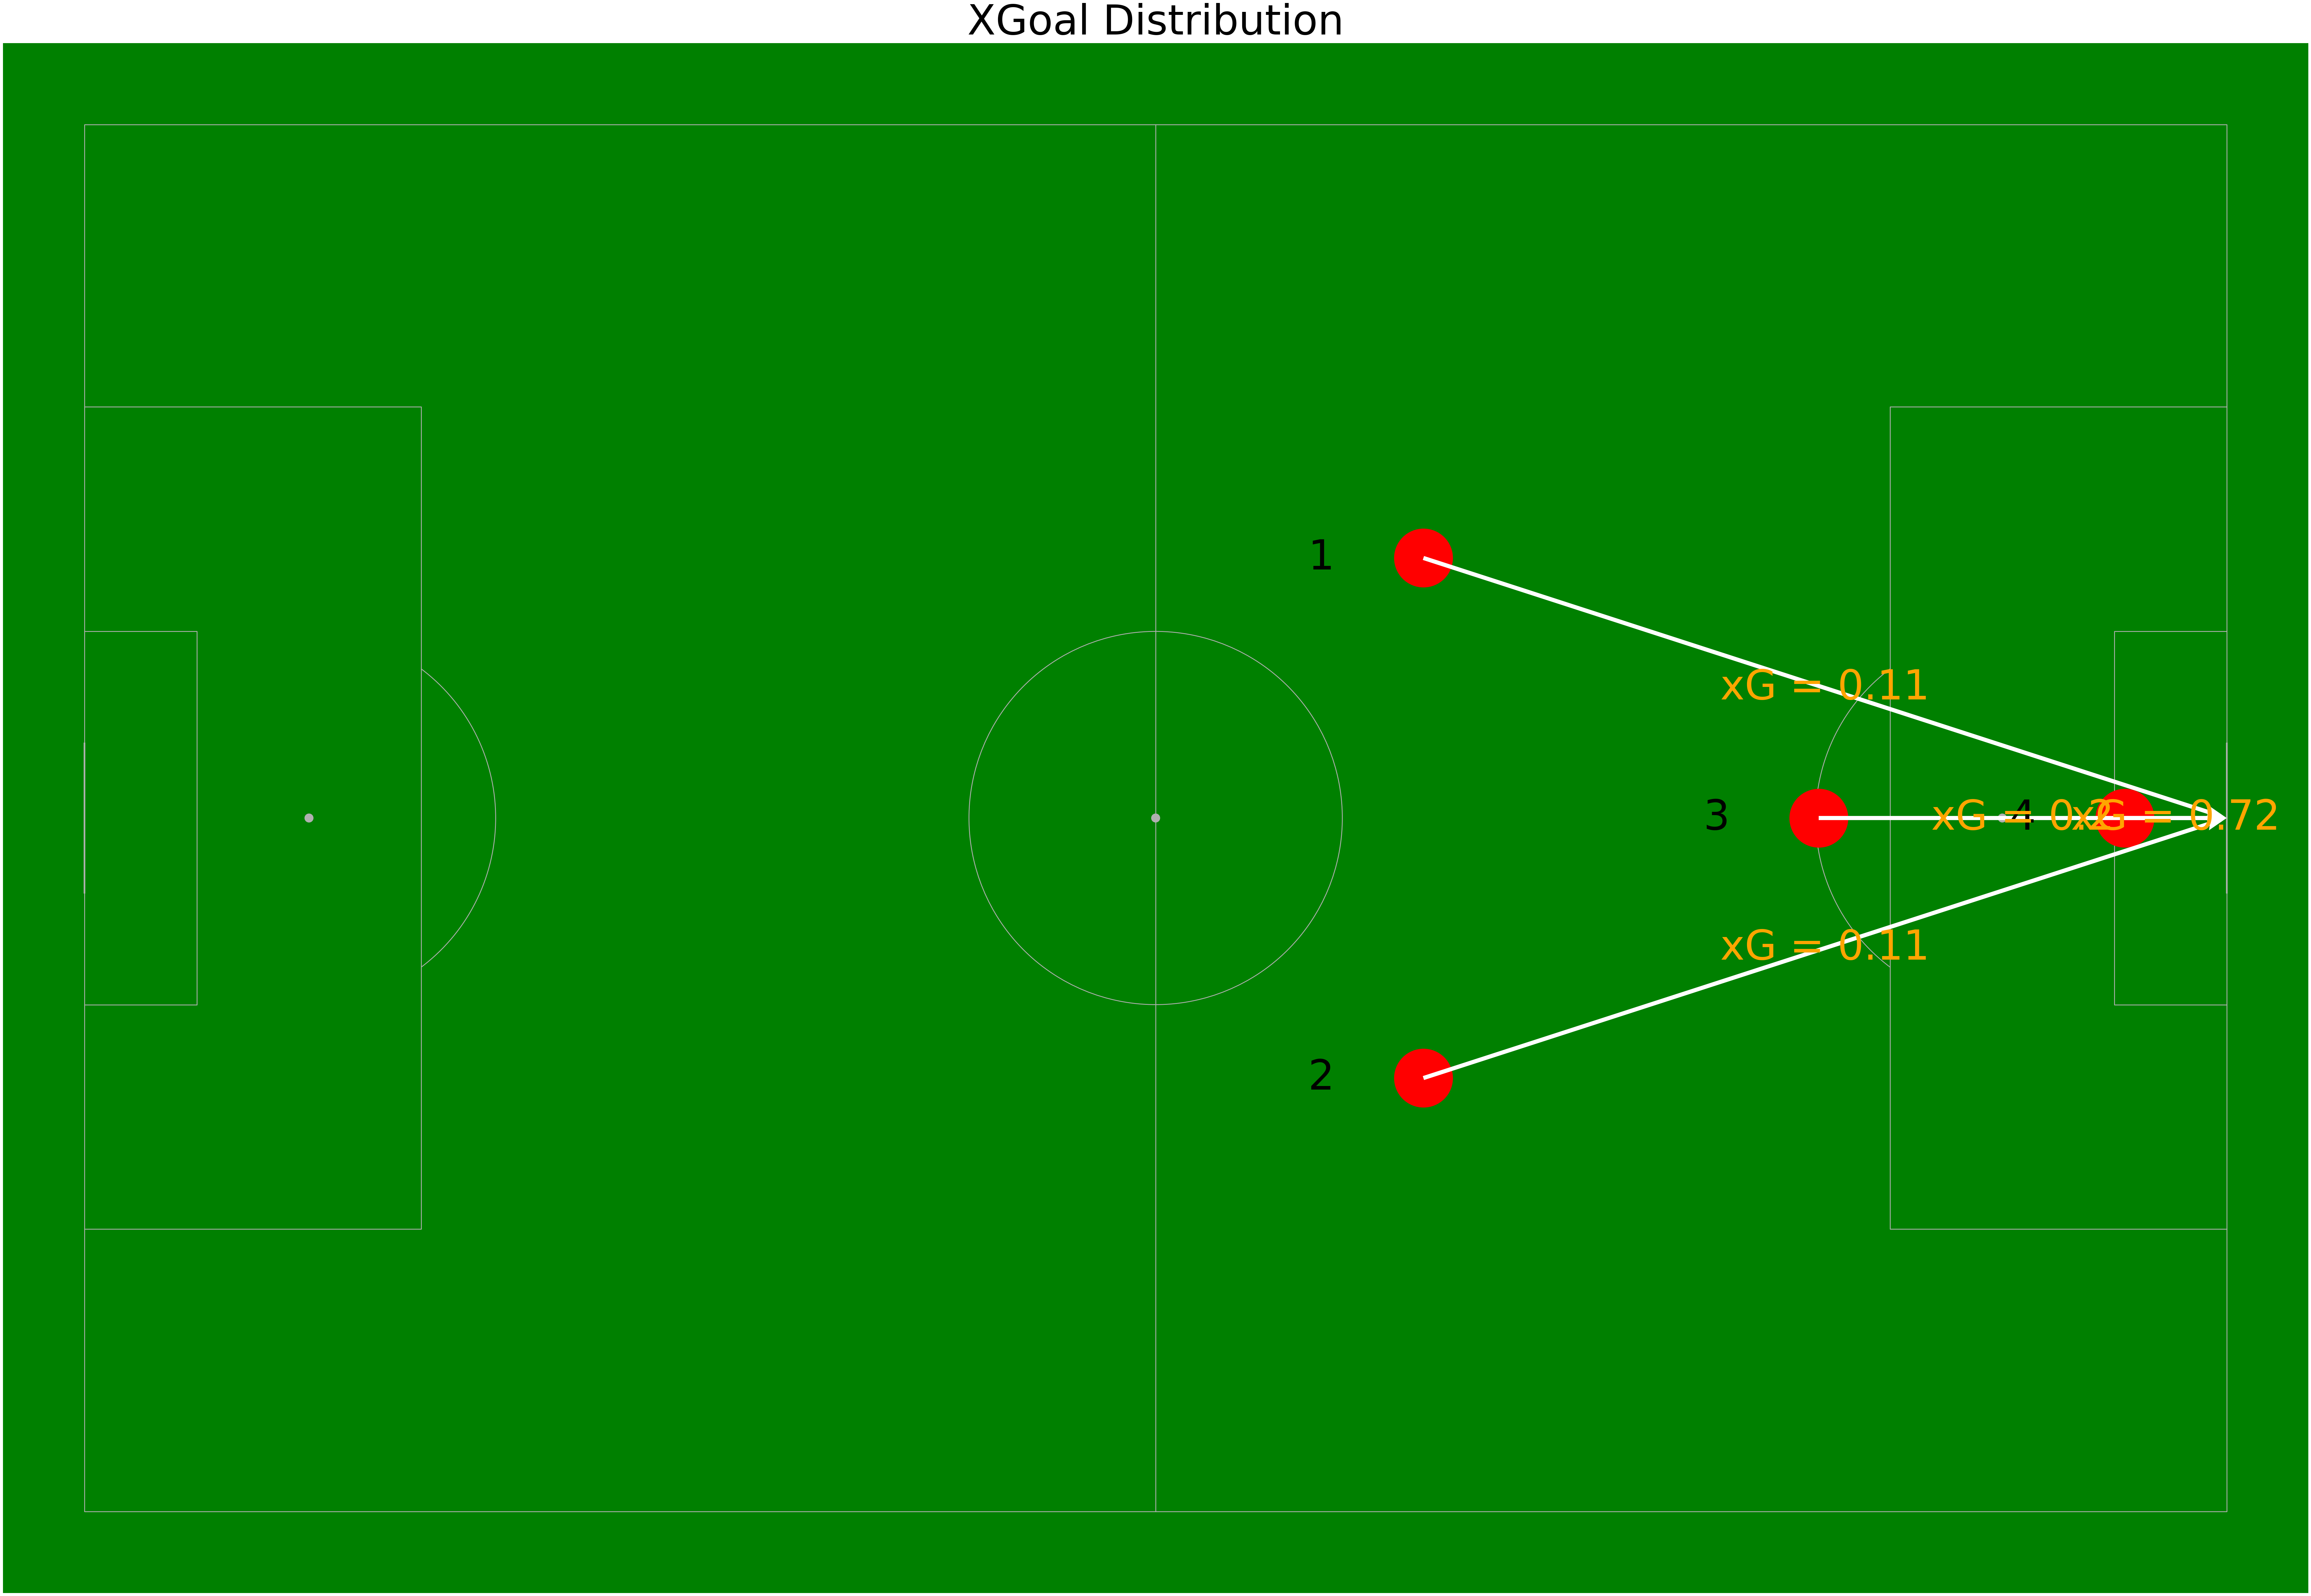

In [ ]:
# PLOT GOAL PROBABILITY INTO PITCH IMAGE
def plot_goal_probability_network(raw_input_from_csv, xgoal_final_df):
    pitchXGoal = Pitch(pitch_type="custom", pitch_length=105, pitch_width=68, pitch_color="green")
    fig, ax = pitchXGoal.draw(figsize=(100,80), constrained_layout=True, tight_layout=False)
    ax.set_title("XGoal Distribution", fontsize=100)

    timestamps_sorted = sorted(raw_input_from_csv['timestamp'].unique())
    for timestamp in timestamps_sorted:
        raw_input_this_timestamp = raw_input_from_csv[raw_input_from_csv['timestamp'] == timestamp]
        unique_player_ids_this_timestamp = raw_input_this_timestamp['player_id'].unique()

        for player_id in unique_player_ids_this_timestamp:
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            pitchXGoal.scatter(x=start_x, y=start_y, color="red", ax=ax, s=20000)
            ax.annotate(text=player_id, xy=(start_x - 5, start_y), ha="center", va="center", size=100)

        for player_id in unique_player_ids_this_timestamp:
            specific_row_xgoal_df = xgoal_final_df.loc[xgoal_final_df["player_id"] == player_id, ["is_home_team", "probability_score"]].iloc[0]
            start_x = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_x"].iloc[0]
            start_y = raw_input_this_timestamp.loc[raw_input_this_timestamp["player_id"] == player_id, "coordinate_y"].iloc[0]
            end_x = 105 if (specific_row_xgoal_df['is_home_team'] == 1) else 0
            end_y = 34

            pitchXGoal.arrows(xstart=start_x, ystart=start_y, xend=end_x, yend=end_y, ax=ax, color="white", width=10)
            x_line = (end_x + start_x) / 2
            y_line = (end_y + start_y) / 2   
            ax.annotate(text=("xG = " + str(round(specific_row_xgoal_df["probability_score"], 2))), xy=(x_line, y_line), ha="center", va="center", size=100, color="orange")
    
    plt.show()

plot_goal_probability_network(raw_input_coordinate_player_df, xgoal_dataframes_test)